In [1]:
import os
os.chdir('../ssl_neuron/')

In [2]:
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from allensdk.core.cell_types_cache import CellTypesCache

from allensdk.api.queries.glif_api import GlifApi
import allensdk.core.json_utilities as json_utilities

In [3]:
from ssl_neuron.datasets import AllenDataset

/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
config = json.load(open('./ssl_neuron/configs/config.json'))
config['data']['n_nodes'] = 1000

In [5]:
ctc = CellTypesCache(manifest_file='./ssl_neuron/data/cell_types/manifest.json')

In [6]:
dset = AllenDataset(config, mode='all')

430it [00:07, 55.84it/s] 


In [7]:
glif_api = GlifApi()

In [17]:
model_ids = []
model_vars = []
has_model = []
cell_ids = []
for cell_id in dset.cell_ids:
    nm = glif_api.get_neuronal_models(cell_id)
    if len(nm) < 1:
        # print(f'{cell_id}*, ', end='')
        has_model.append(False)
        continue
    nm = nm[0]['neuronal_models']
    model_id = None
    for model in nm:
        if '3' in model['name'][:2]: # get basic LIF neurons
            model_id = model['id']
            try:
                var = model['neuronal_model_runs'][0]['explained_variance_ratio']
            except:
                var = None
            break
    if model_id is None:
        # print(f'{cell_id}-, ', end='')
        has_model.append(False)
        continue
    model_ids.append(model_id)
    has_model.append(True)
    cell_ids.append(cell_id)
    model_vars.append(var)
# print('')

In [71]:
print(len(model_ids))

244


0.6984018512508208


(array([ 2.,  3.,  0.,  3.,  8., 32., 63., 72., 27., 34.]),
 array([-0.00511748,  0.09367799,  0.19247346,  0.29126893,  0.3900644 ,
         0.48885987,  0.58765534,  0.68645081,  0.78524628,  0.88404174,
         0.98283721]),
 <BarContainer object of 10 artists>)

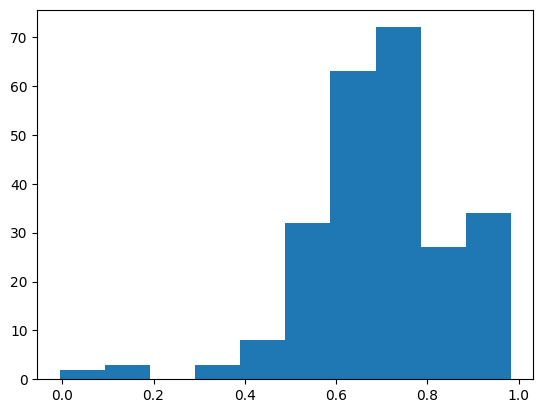

In [78]:
print(np.mean(model_vars))
plt.hist(model_vars)

In [9]:
latents = np.load('../analysis/latents.npy')
latents = latents[np.array(has_model)]

In [19]:
configs = glif_api.get_neuron_configs(model_ids)

In [20]:
configs[model_ids[0]]

{'El_reference': -0.0790417277018229,
 'C': 6.072689987399939e-11,
 'asc_amp_array': [-2.3825265478178427e-11, -2.9206473034028727e-10],
 'init_threshold': 0.04294493489668067,
 'threshold_reset_method': {'params': {}, 'name': 'inf'},
 'th_inf': 0.04294493489668067,
 'spike_cut_length': 29,
 'init_AScurrents': [0.0, 0.0],
 'init_voltage': 0.0,
 'threshold_dynamics_method': {'params': {}, 'name': 'inf'},
 'voltage_reset_method': {'params': {}, 'name': 'zero'},
 'extrapolation_method_name': 'endpoints',
 'dt': 5e-05,
 'voltage_dynamics_method': {'params': {}, 'name': 'linear_forward_euler'},
 'El': 0.0,
 'asc_tau_array': [0.03333333333333334, 0.0033333333333333335],
 'R_input': 287519215.47957283,
 'AScurrent_dynamics_method': {'params': {}, 'name': 'exp'},
 'AScurrent_reset_method': {'params': {'r': [1.0, 1.0]}, 'name': 'sum'},
 'dt_multiplier': 10,
 'th_adapt': None,
 'coeffs': {'a': 1,
  'C': 1,
  'b': 1,
  'G': 1,
  'th_inf': 0.684653025255221,
  'asc_amp_array': [1.0, 1.0]},
 'type'

In [16]:
configs[model_ids[0]]

{'El_reference': -0.0790417277018229,
 'C': 6.072689987399939e-11,
 'asc_amp_array': [-2.3825265478178427e-11, -2.9206473034028727e-10],
 'init_threshold': 0.04294493489668067,
 'threshold_reset_method': {'params': {}, 'name': 'inf'},
 'th_inf': 0.04294493489668067,
 'spike_cut_length': 29,
 'init_AScurrents': [0.0, 0.0],
 'init_voltage': 0.0,
 'threshold_dynamics_method': {'params': {}, 'name': 'inf'},
 'voltage_reset_method': {'params': {}, 'name': 'zero'},
 'extrapolation_method_name': 'endpoints',
 'dt': 5e-05,
 'voltage_dynamics_method': {'params': {}, 'name': 'linear_forward_euler'},
 'El': 0.0,
 'asc_tau_array': [0.03333333333333334, 0.0033333333333333335],
 'R_input': 255066542.81734213,
 'AScurrent_dynamics_method': {'params': {}, 'name': 'none'},
 'AScurrent_reset_method': {'params': {}, 'name': 'none'},
 'dt_multiplier': 10,
 'th_adapt': None,
 'coeffs': {'a': 1,
  'C': 1,
  'b': 1,
  'G': 1,
  'th_inf': 0.8089171303795053,
  'asc_amp_array': [1.0, 1.0]},
 'type': 'GLIF'}

In [21]:
def flatten_dict(dictionary, prefix=''):
    flattened = {}
    for key, value in dictionary.items():
        if isinstance(value, (list, tuple)):
            for i, item in enumerate(value):
                flattened[f'{prefix}{key}_{i}'] = item
        elif isinstance(value, dict):
            if len(value) > 0:
                flattened.update(flatten_dict(value, key + '_'))
        else:
            flattened[f'{prefix}{key}'] = value
    return flattened
model_data = []
for cell_id, model_id in zip(cell_ids, model_ids):
    model_config = configs[model_id]
    keep_config = flatten_dict(model_config)
    keep_config['model_id'] = model_id
    keep_config['cell_id'] = cell_id
    # keep_config = {'model_id': model_id, 'cell_id': cell_id}
    # keep_config['El_reference'] = model_config['El_reference']
    # keep_config['C'] = model_config['C']
    # keep_config['asc_amp_array_0'] = model_config['asc_amp_array'][0]
    # keep_config['asc_amp_array_1'] = model_config['asc_amp_array'][1]
    # keep_config['init_threshold'] = model_config['init_threshold']
    # keep_config['th_inf'] = model_config['th_inf']
    # keep_config['spike_cut_length'] = model_config['spike_cut_length']
    # keep_config['asc_tau_array_0'] = model_config['asc_tau_array'][0] # four distinct values: [0.033.., 0.01, 0.33.., 0.1]
    # keep_config['asc_tau_array_1'] = model_config['asc_tau_array'][1]
    # keep_config['R_input'] = model_config['R_input']
    # keep_config['coef_th_inf'] = model_config['coeffs']['th_inf']
    # keep_config['coef_asc_amp_array_0'] = model_config['coeffs']['asc_amp_array'][0]
    # keep_config['coef_asc_amp_array_1'] = model_config['coeffs']['asc_amp_array'][1]
    model_data.append(keep_config)

In [22]:
model_df = pd.DataFrame(model_data)

In [23]:
model_df.columns

Index(['El_reference', 'C', 'asc_amp_array_0', 'asc_amp_array_1',
       'init_threshold', 'threshold_reset_method_name', 'th_inf',
       'spike_cut_length', 'init_AScurrents_0', 'init_AScurrents_1',
       'init_voltage', 'threshold_dynamics_method_name',
       'voltage_reset_method_name', 'extrapolation_method_name', 'dt',
       'voltage_dynamics_method_name', 'El', 'asc_tau_array_0',
       'asc_tau_array_1', 'R_input', 'AScurrent_dynamics_method_name',
       'params_r_0', 'params_r_1', 'AScurrent_reset_method_name',
       'dt_multiplier', 'th_adapt', 'coeffs_a', 'coeffs_C', 'coeffs_b',
       'coeffs_G', 'coeffs_th_inf', 'coeffs_asc_amp_array_0',
       'coeffs_asc_amp_array_1', 'type', 'model_id', 'cell_id'],
      dtype='object')

In [24]:
field = 'model_id'
print(model_df[field].min())
print(model_df[field].max())
print(model_df[field].nunique())
print(model_df[field].unique()[:5])

480051204
637920410
244
[566281824 566284003 566284338 566285504 566290552]


In [25]:
for column in model_df.columns:
    if model_df[column].nunique() <= 1:
        model_df.drop(column, axis=1, inplace=True)
if np.max(np.abs(model_df['th_inf'] - model_df['init_threshold'])) < 1e-6:
    model_df.drop('th_inf', axis=1, inplace=True)
model_df.columns

Index(['El_reference', 'C', 'asc_amp_array_0', 'asc_amp_array_1',
       'init_threshold', 'spike_cut_length', 'asc_tau_array_0',
       'asc_tau_array_1', 'R_input', 'coeffs_th_inf', 'model_id', 'cell_id'],
      dtype='object')

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVR

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [111]:
field = 'coeffs_th_inf'

np.random.seed(0)
perm = np.random.permutation(len(latents))

target = model_df[field].to_numpy()
target = StandardScaler().fit_transform(target[:, None]).squeeze()

gscv = GridSearchCV(SVR(), {'C': np.logspace(-6, 3, 10)})
gscv.fit(latents[perm], target[perm])

print(gscv.score(latents, target))

pd.DataFrame(gscv.cv_results_)

0.31883733905527456


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004526,0.000281,0.001754,0.000434,0.000001,{'C': 1e-06},-0.026621,-0.018621,-0.031712,-0.119613,-0.000156,-0.039344,0.041541,8
1,0.004230,0.000085,0.001526,0.000056,0.00001,{'C': 1e-05},-0.026593,-0.018577,-0.031698,-0.119607,-0.000128,-0.039321,0.041551,7
2,0.004238,0.000032,0.001500,0.000067,0.0001,{'C': 0.0001},-0.026317,-0.018142,-0.031664,-0.119550,0.000146,-0.039105,0.041642,6
3,0.004202,0.000090,0.001451,0.000077,0.001,{'C': 0.001},-0.024951,-0.015285,-0.030371,-0.118277,0.002994,-0.037178,0.042109,5
4,0.004208,0.000135,0.001534,0.000045,0.01,{'C': 0.01},-0.008324,0.013579,-0.014928,-0.091108,0.026996,-0.014757,0.041030,4
5,0.003809,0.001418,0.001287,0.000427,0.1,{'C': 0.1},0.030856,0.121735,0.028346,-0.037363,0.119650,0.052645,0.060712,2
6,0.003133,0.000126,0.000960,0.000069,1.0,{'C': 1.0},0.070605,0.210612,0.052738,-0.028027,0.181364,0.097459,0.087535,1
7,0.004759,0.000278,0.001029,0.000168,10.0,{'C': 10.0},-0.031655,0.045350,0.185343,-0.154090,0.046984,0.018386,0.111060,3
8,0.012323,0.001056,0.001101,0.000116,100.0,{'C': 100.0},-0.549671,-0.266761,-0.225184,-0.631142,-0.996003,-0.533752,0.279253,9
9,0.022933,0.002587,0.001276,0.000227,1000.0,{'C': 1000.0},-1.408841,-1.024312,-0.471069,-1.247640,-2.170257,-1.264424,0.552944,10
